<a href="https://colab.research.google.com/github/zek12/TensorFlow_notebooks/blob/master/classification_with_TensorFlow_on_MNIST_and_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Classification with MNIST dataset

## 5.1. Preload data with Keras

In this tutorial, we are going to use the dataset MNIST, from Keras. This dataset is composed of 70,000 pictures of 28x28 pixels, in grayscale (each pixel taking values between 0-255), of digits (between 0 and 9) written by hand. The dataset is split into a training set (composed of 60,000 samples) and a test set (composed of 10,000 samples).

In [96]:
import tensorflow as tf
import numpy as np

In [97]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We can print the 8th image of the training set:

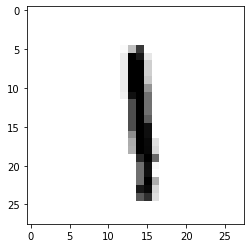

In [98]:
import matplotlib.pyplot as plt
plt.imshow(x_train[8], cmap = plt.cm.binary)

... and its corresponding label:

In [99]:
print(y_train[8])

1


The training set is formed by 60,000 pictures of 28x28 pixels:

In [100]:
print(x_train.ndim)
print(x_train.shape)
print(x_train.dtype)

3
(60000, 28, 28)
uint8


The test set is formed by 10,000 pictures of 28x28 pixels:

In [101]:
print(x_test.ndim)
print(x_test.shape)
print(x_test.dtype)

3
(10000, 28, 28)
uint8


We can slice our data, for example take the first 100 pictures:

In [102]:
my_slice = x_train[1:100:, :]
print(my_slice.shape)

(99, 28, 28)


Another way of doing the same:

In [103]:
my_slice = x_train[1:100, 0:28, 0:28]
print(my_slice.shape)

(99, 28, 28)


If we want to select the 14x14 pixels in the bottom-right corner of all pictures:

In [104]:
my_slice = x_train[:, 14:, 14:]
print(my_slice.shape)

(60000, 14, 14)


And if we want to select the 14x14 pixels in the centre of all pictures:

In [105]:
my_slice = x_train[:, 7:-7, 7:-7]
print(my_slice.shape)

(60000, 14, 14)


## 5.2. Preprocessing of input data

Each image in our input data consists of 28x28 pixels, each taking values between [0-255]. It's convenient to scale the pixels in a range [0-1], aka **normalization**, because this helps the training process to converge. Furthermore, in a neural network, we don't use values that are mich higher than the weights in the network, or data with heterogenous values between themselves.

In [106]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

Another useful transformation is **re-shaping** of data, i.e. instead of having a vector of matrices (each of 28x28 pixels), we can have a vector of vectors of length 28x28. This is because this is the format that a neural network accepts as input.

In [107]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [108]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

In [109]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Finally, we can perform **one-hot encoding** on the labels (`y_train` and `y_test`).

In [110]:
from tensorflow.keras.utils import to_categorical

In [111]:
print(y_train[0])
print(y_test[0])

5
7


In [112]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


In [113]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [114]:
print(y_train[0])
print(y_test[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [115]:
print(y_train.shape)
print(y_test.shape)

(60000, 10)
(10000, 10)


We now have the data in the format that we need in order to train our neural network.

## 5.3. Model definition

In our example, we will use class `Sequential`, which defines our model as a sequence of layers. Each layer will distill the input data to obtain the desired output.

Keras offers an API to define more complex models; more information in https://keras.io/guides/functional_api/.

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [117]:
model = Sequential()
model.add(Dense(10, activation = 'sigmoid', input_shape = (784,)))
model.add(Dense(10, activation = 'softmax'))

Here, we defined our model as a neural network with 2 layers (1 input and 1 output layer) with 10 neurons each, densely connected.

In [118]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


We can see that the first layer has a total of 7850 parameters: these correspond to 784 input pixels * 10 input neurons = 7840 + 1 input bias in each neuron = **7850**.

The second layer has 110 parameters, which correspond to 10 outputs from first layer * 10 neurons in the second layer + 10 input biases in each neuron = **110**.

The sum of 7850 + 110 = **7960**.

We could also define initialization values to the weights of the nodes. This can be specified as an argument in `Dense()` function. More information in https://keras.io/api/layers/initializers/#usage-of-initializers.

## 5.4. Configure the training process

Before we can start training our model, we need to configure the training process with the `compile()` method.

In particular, we need to specify the following arguments:
- **loss**: this is the loss function, which will evaluate the degree of error between actual and predicted labels. For each observation, a prediction is made, then this loss function is calculated by comparing actual vs predicted values, and then the weights and biases are updated in a way that tries to minimize the loss function for the next observation.
- **optimizer**: this is how the model is updated based on the data it sees and its loss function. In this example, we will use `stochastic gradient descent` (sgd). Between observations, and after the loss function is calculated, this optimizer guides how the weights and biases will be updated.
- **metrics**: this is the metric to monitor the training and testing process. In this example, we will use `accuracy`. These will be the metrics that will appear in between epochs. These metrics do not guide the training process, and they are just for reporting to the user.

In [119]:
model.compile(loss = "categorical_crossentropy",
              optimizer = "sgd",
              metrics = ['accuracy'])

## 5.5. Train the model

In [120]:
model.fit(x_train, y_train, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.9080 - accuracy: 0.5443
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2683 - accuracy: 0.7639
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.9371 - accuracy: 0.8114
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7673 - accuracy: 0.8343
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6652 - accuracy: 0.8490


This trains the model in 5 iterations (epochs). If argument ```batch_size``` is not specified in model.fit(), the default will be 32 samples. This means that the model will take 32 observations from the Training set, predict values, calculate loss function, apply optimizer to minimize the loss function and update the weights and biases before taking the next batch of 32 samples.

## 5.6. Model assessment

We can now evaluate the model's performance using the ```evaluate()``` function. This function returns 2 values.

In [121]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.6130 - accuracy: 0.8602


In [122]:
print('Test accuracy:', round(test_acc, 2))

Test accuracy: 0.86


This accuracy is telling us that the model is correctly labelling ~85% of samples that were never visited (Test set).

**Confusion Matrix:**

In [123]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observed')
    plt.xlabel('Predicted')

313/313 [==============================] - 0s 1ms/step


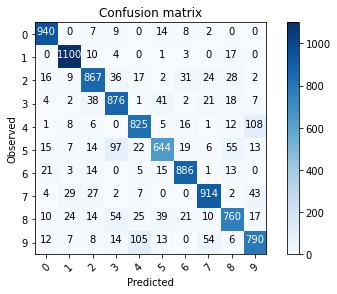

In [124]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Report PPV (aka Precision), Sensitivity (aka Recall), Specificity (aka TNR, True Negative Rate) and NPV:

In [125]:
import sklearn.metrics
import math
import pandas as pd
def matrix_metrics(Y_true, Y_pred_classes, beta, label):

  data = {'actual': Y_true, 'pred': Y_pred_classes}
  df1 = pd.DataFrame(data)


  TP = df1.loc[(df1['actual'] == label) & (df1['pred'] == label)].shape[0]
  TN = df1.loc[(df1['actual'] != label) & (df1['pred'] != label)].shape[0]
  FP = df1.loc[(df1['actual'] != label) & (df1['pred'] == label)].shape[0]
  FN = df1.loc[(df1['actual'] == label) & (df1['pred'] != label)].shape[0]

  Population = TN+FN+TP+FP
  Prevalence = round( (TP+FP) / Population,2)
  Accuracy   = round( (TP+TN) / Population,4)
  Precision  = round( TP / (TP+FP),4 )
  NPV        = round( TN / (TN+FN),4 )
  FDR        = round( FP / (TP+FP),4 )
  FOR        = round( FN / (TN+FN),4 ) 
  check_Pos  = Precision + FDR
  check_Neg  = NPV + FOR
  Recall     = round( TP / (TP+FN),4 )
  FPR        = round( FP / (TN+FP),4 )
  FNR        = round( FN / (TP+FN),4 )
  TNR        = round( TN / (TN+FP),4 ) 
  check_Pos2 = Recall + FNR
  check_Neg2 = FPR + TNR
  LRPos      = round( Recall/FPR,4 ) 
  LRNeg      = round( FNR / TNR ,4 )
  DOR        = round( LRPos/LRNeg)
  F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
  FBeta      = round ( (1+beta**2)*((Precision*Recall)/((beta**2 * Precision)+ Recall)) ,4)
  MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
  BM         = Recall+TNR-1
  MK         = Precision+NPV-1
  mat_met = pd.DataFrame({
  'Metric':['TP','TN','FP','FN','Prevalence','Accuracy','Precision/PPV','NPV','FDR','FOR','check_Pos','check_Neg','Recall/Sensitivity','FPR','FNR','TNR/Specificty','check_Pos2','check_Neg2','LR+','LR-','DOR','F1','FBeta','MCC','BM','MK'],     'Value':[TP,TN,FP,FN,Prevalence,Accuracy,Precision,NPV,FDR,FOR,check_Pos,check_Neg,Recall,FPR,FNR,TNR,check_Pos2,check_Neg2,LRPos,LRNeg,DOR,F1,FBeta,MCC,BM,MK]})
  return (mat_met)

In [126]:
beta = 0.4
label = 0
mat_met = matrix_metrics(Y_true, Y_pred_classes, beta, label)
mat_met

,Metric,Value
0,TP,940.0000
1,TN,8937.0000
2,FP,83.0000
3,FN,40.0000
4,Prevalence,0.1000
5,Accuracy,0.9877
6,Precision/PPV,0.9189
7,NPV,0.9955
8,FDR,0.0811
9,FOR,0.0045


In [127]:
mat_met[mat_met['Metric'].isin(['Precision/PPV', 'Recall/Sensitivity', 'TNR/Specificty', 'NPV', 'F1'])]

,Metric,Value
6,Precision/PPV,0.9189
7,NPV,0.9955
12,Recall/Sensitivity,0.9592
15,TNR/Specificty,0.9908
21,F1,0.9386


## 5.7. Generate predicitons


We now proceed to make predictions on unseen observations, using `predict()` method from Keras.

To test the function, we can sample a random observation, e.g. 11, and make a prediction and compare it with the real label.

The real label of element 11 is "6":

In [129]:
print(y_test[11])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


... and the predicted value is:

In [130]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [138]:
[round(x, 2) for x in predictions[11]]

[0.08, 0.03, 0.14, 0.02, 0.06, 0.05, 0.5, 0.0, 0.1, 0.01]

In [132]:
np.argmax(predictions[11])

6

We can see that the predicted value is also "6".

We can also see that the sum of the probabilities is 1:

In [139]:
np.sum(predictions[11])

1.0000001

## 5.8. Fashion-MNIST

This dataset contains 70,000 images of clothes articles in grey scale with 10 labels. Each picture is 28x28 pixels.

60,000 images are used to train the model; the remaining 10,000 are used to evaluate the model.

**Prepare de data:**

In [21]:
%tensorflow_version 2.X
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2


Load the data:

In [22]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [23]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

The labels are numbers from 0 to 9. We can rename them to actual string names:

In [24]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Re-scale the pixels in the images to 0-1:

In [25]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

Check that the shape of the images are as desired:

In [26]:
print("train_images.shape:",train_images.shape)
print("len(train_labels:",len(train_labels))
print("test_images.shape:",test_images.shape)
print("len(test_labels):",len(test_labels))

train_images.shape: (60000, 28, 28)
len(train_labels: 60000
test_images.shape: (10000, 28, 28)
len(test_labels): 10000


Show a subset of images in the Training set along with their labels:

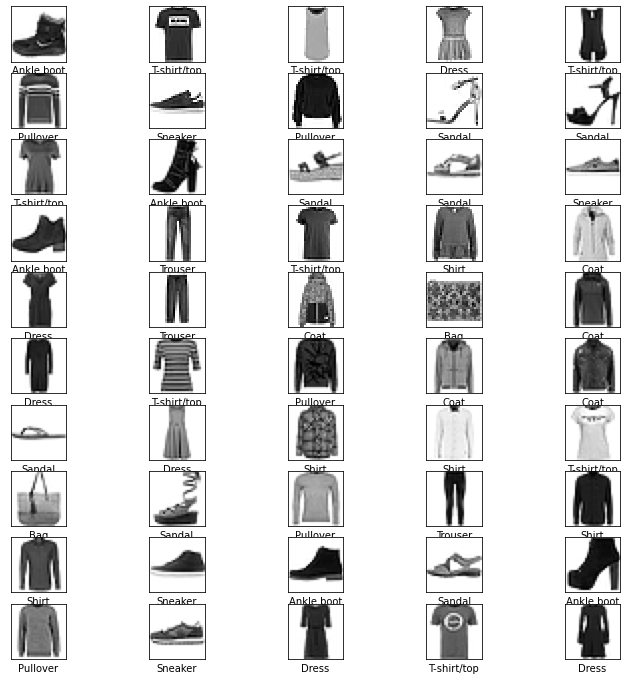

In [27]:
plt.figure(figsize=(12,12))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

**Define the model**. Here, we can use the function `Flatten()` from Keras to automatically re-shape the 28x28 matrix into a 784 vector as input:


In [28]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape = (28, 28)))
model.add(Dense(10, activation = "sigmoid"))
model.add(Dense(10, activation = "softmax"))

We can see with the `summary()` method that the first layer of the network does not need any parameter (`Param #` column).

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                7850      
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


**Set up the model**. We can configure the model with the `compile()` function.

In [30]:
model.compile(optimizer = "sgd", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

Train the model:

In [31]:
model.fit(train_images, train_labels, epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.7442 - accuracy: 0.4981
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1866 - accuracy: 0.6699
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9617 - accuracy: 0.6986
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.8499 - accuracy: 0.7205
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.7804 - accuracy: 0.7392


All images are passed through the network 5 times/epochs during the training. The accuracy increases while the loss decreases with each epoch.

**Model assessment:**

In [32]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy: ", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.7698 - accuracy: 0.7403
Test accuracy:  0.7402999997138977


We can see that the accuracy obtained from the Test set is similar than that of the Training set.

**Make predictions:**

In [33]:
predictions = model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


In [34]:
predictions[5]

array([5.9778310e-02, 8.0860078e-01, 3.7025701e-02, 3.1486224e-02,
       1.4369011e-02, 1.3483312e-02, 3.1796571e-02, 9.2243659e-04,
       3.4458452e-04, 2.1930109e-03], dtype=float32)

In [35]:
np.argmax(predictions[5])

1

The model is most sure that the 5th element is of class "1". Let's see the actual label:

In [36]:
test_labels[5]

1

We define below 2 functions:

*   **plot_image()** plots the image of the article with a caption in blue if the prediction was correct, or in red if the prediction was wrong.
*   **plot_value_array()** plots barplots with probabilities of each predicted class. A barplot in black means that the predicted class was correct; a barplot in red means that the predicted class was wrong.



In [37]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)    

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#00FF00")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('black')

Element 5 from the Test set was predicted correctly:

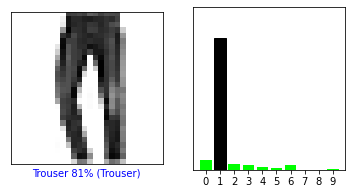

In [38]:
i = 5
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

...whereas element 8 was predicted incorrectly:

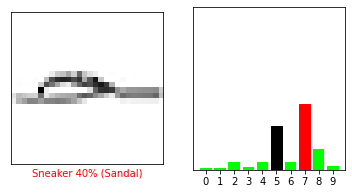

In [39]:
i = 8
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

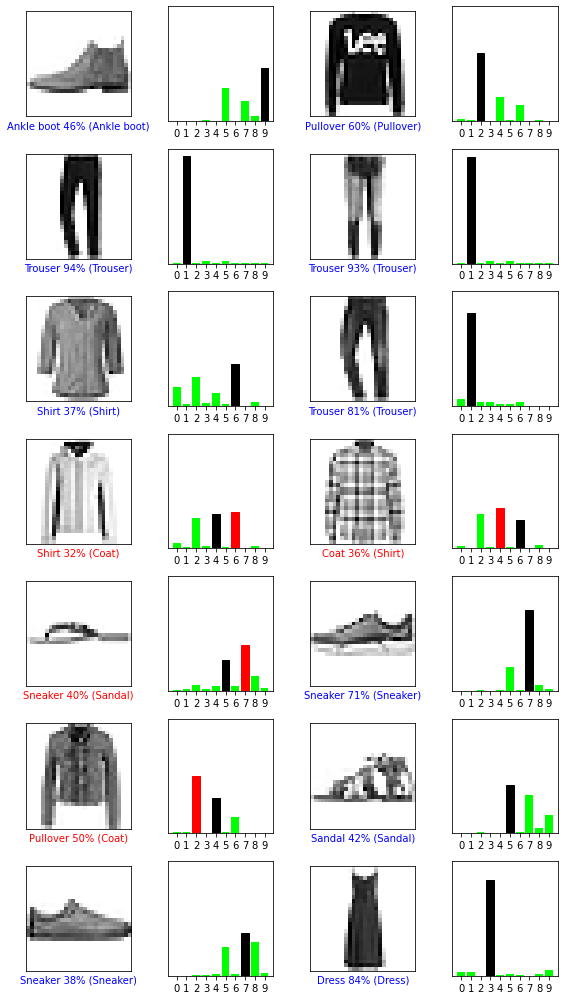

In [40]:
num_rows = 7
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)     
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()


**Improve the model.** We can see that the accuracy obtained (74%) is much lower than that of the MNIST example (86%).
We can improve our model by trying different optimizers, for  example **Adam**.

In [41]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=5)

test_loss, test_acc = model.evaluate(test_images,  test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0027 - accuracy: 0.7285
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5593 - accuracy: 0.8239
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4765 - accuracy: 0.8397
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4412 - accuracy: 0.8474
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.4479 - accuracy: 0.8427

Test accuracy: 0.8427000045776367
